### Files

* train.csv - historical data including Sales
* test.csv - historical data excluding Sales
* sample_submission.csv - a sample submission file in the correct format
* store.csv - supplemental information about the stores

### Fields
* Id - an Id that represents a (Store, Date) duple within the test set
* Store - a unique Id for each store
* Sales - the turnover for any given day (this is what you are predicting)
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [1]:
library(data.table)
library(zoo)


Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



In [5]:
install.packages("forecast",repos = "http://cran.us.r-project.org")

also installing the dependencies 'quadprog', 'tseries', 'fracdiff', 'lmtest', 'timeDate', 'RcppArmadillo'



package 'quadprog' successfully unpacked and MD5 sums checked
package 'tseries' successfully unpacked and MD5 sums checked
package 'fracdiff' successfully unpacked and MD5 sums checked
package 'lmtest' successfully unpacked and MD5 sums checked
package 'timeDate' successfully unpacked and MD5 sums checked
package 'RcppArmadillo' successfully unpacked and MD5 sums checked
package 'forecast' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\ZekeLabs\AppData\Local\Temp\Rtmpg1YFv3\downloaded_packages


In [6]:
library(ggplot2)

In [5]:
test <- read.csv("rossmann-data/test.csv/test.csv")
train <- read.csv("rossmann-data/train.csv/train.csv")
store <- read.csv("rossmann-data/store.csv/store.csv")

In [6]:
train

Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1,5,2015-07-31,5263,555,1,1,0,1
2,5,2015-07-31,6064,625,1,1,0,1
3,5,2015-07-31,8314,821,1,1,0,1
4,5,2015-07-31,13995,1498,1,1,0,1
5,5,2015-07-31,4822,559,1,1,0,1
6,5,2015-07-31,5651,589,1,1,0,1
7,5,2015-07-31,15344,1414,1,1,0,1
8,5,2015-07-31,8492,833,1,1,0,1
9,5,2015-07-31,8565,687,1,1,0,1
10,5,2015-07-31,7185,681,1,1,0,1


In [7]:
test

Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
1,1,4,2015-09-17,1,1,0,0
2,3,4,2015-09-17,1,1,0,0
3,7,4,2015-09-17,1,1,0,0
4,8,4,2015-09-17,1,1,0,0
5,9,4,2015-09-17,1,1,0,0
6,10,4,2015-09-17,1,1,0,0
7,11,4,2015-09-17,1,1,0,0
8,12,4,2015-09-17,1,1,0,0
9,13,4,2015-09-17,1,1,0,0
10,14,4,2015-09-17,1,1,0,0


In [16]:
str(store)

Classes 'data.table' and 'data.frame':	1115 obs. of  10 variables:
 $ Store                    : int  1 2 3 4 5 6 7 8 9 10 ...
 $ StoreType                : chr  "c" "a" "a" "c" ...
 $ Assortment               : chr  "a" "a" "a" "c" ...
 $ CompetitionDistance      : int  1270 570 14130 620 29910 310 24000 7520 2030 3160 ...
 $ CompetitionOpenSinceMonth: int  9 11 12 9 4 12 4 10 8 9 ...
 $ CompetitionOpenSinceYear : int  2008 2007 2006 2009 2015 2013 2013 2014 2000 2009 ...
 $ Promo2                   : int  0 1 1 0 0 0 0 0 0 0 ...
 $ Promo2SinceWeek          : int  NA 13 14 NA NA NA NA NA NA NA ...
 $ Promo2SinceYear          : int  NA 2010 2011 NA NA NA NA NA NA NA ...
 $ PromoInterval            : chr  "" "Jan,Apr,Jul,Oct" "Jan,Apr,Jul,Oct" "" ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [18]:
train

Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1,5,2015-07-31,5263,555,1,1,0,1
2,5,2015-07-31,6064,625,1,1,0,1
3,5,2015-07-31,8314,821,1,1,0,1
4,5,2015-07-31,13995,1498,1,1,0,1
5,5,2015-07-31,4822,559,1,1,0,1
6,5,2015-07-31,5651,589,1,1,0,1
7,5,2015-07-31,15344,1414,1,1,0,1
8,5,2015-07-31,8492,833,1,1,0,1
9,5,2015-07-31,8565,687,1,1,0,1
10,5,2015-07-31,7185,681,1,1,0,1


In [19]:
store

Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1,c,a,1270,9,2008,0,NA,NA,
2,a,a,570,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
3,a,a,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
4,c,c,620,9,2009,0,NA,NA,
5,a,a,29910,4,2015,0,NA,NA,
6,a,a,310,12,2013,0,NA,NA,
7,a,c,24000,4,2013,0,NA,NA,
8,a,a,7520,10,2014,0,NA,NA,
9,a,c,2030,8,2000,0,NA,NA,
10,a,a,3160,9,2009,0,NA,NA,


In [8]:
test[is.na(test$Open),]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
480,480,622,4,2015-09-17,NA,1,0,0
1336,1336,622,3,2015-09-16,NA,1,0,0
2192,2192,622,2,2015-09-15,NA,1,0,0
3048,3048,622,1,2015-09-14,NA,1,0,0
4760,4760,622,6,2015-09-12,NA,0,0,0
5616,5616,622,5,2015-09-11,NA,0,0,0
6472,6472,622,4,2015-09-10,NA,0,0,0
7328,7328,622,3,2015-09-09,NA,0,0,0
8184,8184,622,2,2015-09-08,NA,0,0,0
9040,9040,622,1,2015-09-07,NA,0,0,0


In [9]:
test$Open[test$Store == 622]

[1] NA NA NA NA  0 NA NA NA NA NA NA  0 NA  1  1  1  1  1  0  1  1  1  1  1  1
[26]  0  1  1  1  1  1  1  0  1  1  1  1  1  1  0  1  1  1  1  1  1  0  1

In [10]:
test[is.na(test)] <- 1

In [11]:
test

Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
1,1,4,2015-09-17,1,1,0,0
2,3,4,2015-09-17,1,1,0,0
3,7,4,2015-09-17,1,1,0,0
4,8,4,2015-09-17,1,1,0,0
5,9,4,2015-09-17,1,1,0,0
6,10,4,2015-09-17,1,1,0,0
7,11,4,2015-09-17,1,1,0,0
8,12,4,2015-09-17,1,1,0,0
9,13,4,2015-09-17,1,1,0,0
10,14,4,2015-09-17,1,1,0,0


In [12]:
test[is.na(test$Open),]

Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday


In [13]:
table(train$Open) / nrow(train)


        0         1 
0.1698933 0.8301067 

In [14]:
table(test$StateHoliday) / nrow(test)


          0           a 
0.995619159 0.004380841 

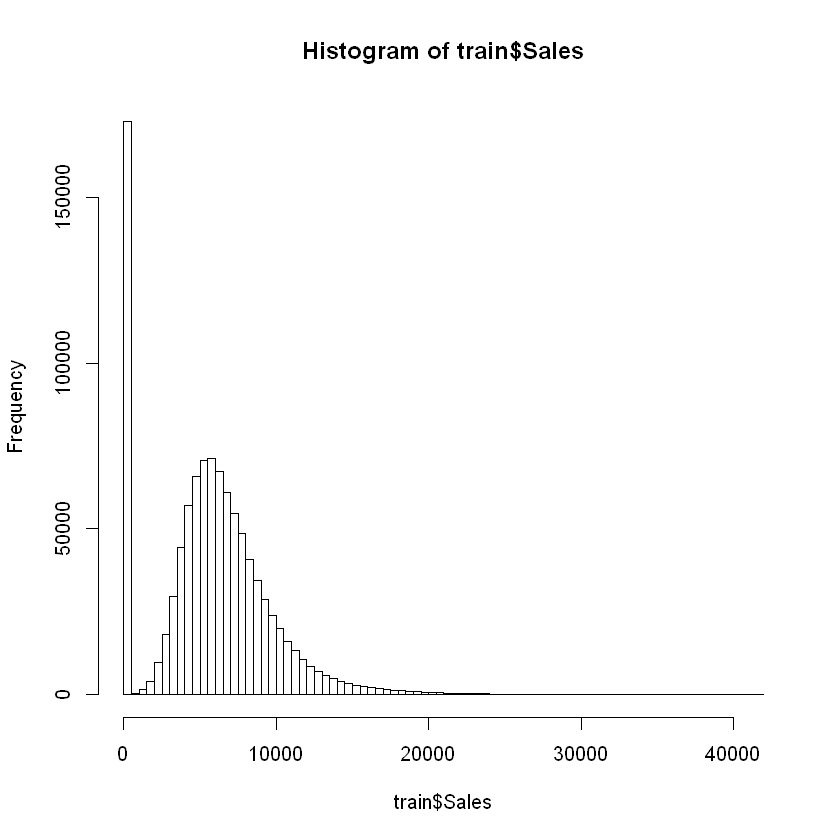

In [15]:
hist(train$Sales, 100)

In [16]:
table(store$StoreType)


  a   b   c   d 
602  17 148 348 